## Importamos librerías

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Vamos a hacer un estudio de la encuesta esta

In [2]:
### cogemos el dataframe (habrá que leerlo de algún sitio), mientras tanto me lo invento
lst1 = ["Jaime","Raquel","Josema","Marta","Laura","Cristina","Gonzalo","Elena","Javi","Dani","Ruben"]
lst2 = [1,4,5,7,7,5,6,2,2,4,4]
lst3 = [2,3,4,5,6,7,7,7,5,5,5]
lst4 = [2,3,1,2,3,4,4,4,6,6,6]
lst5 = [3,2,4,5,7,9,9,9,np.nan,6,6]

df = pd.DataFrame(list(zip(lst1,lst2,lst3,lst4,lst5)), columns = ['Nombre','Variable1','Variable2','Variable3','Variable4'])



Comprobamos la calidad de los datos

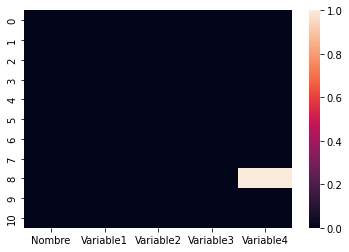

In [3]:
## vemos gráficamente si hay algún nulo

sns.heatmap(df.isna(),vmin = 0,vmax = 1)

In [4]:
## tambien podemos hacer los siguiente:

## donde se ve el número de nulos que hay por variable

df.isna().sum()

Nombre       0
Variable1    0
Variable2    0
Variable3    0
Variable4    1
dtype: int64

Creamos matriz de correlaciones con Spearman (que es para escalas tipo likert va bien)

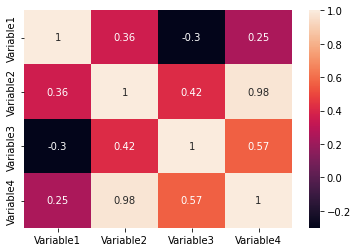

In [5]:
matriz_correlaciones = df.corr(method = 'spearman')

sns.heatmap(matriz_correlaciones,annot = True)

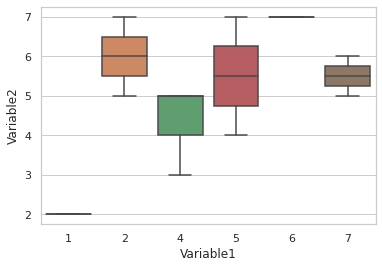

In [6]:
## ahora cogemos y hacemos boxplots por variables para ver cómo evolucionan

sns.set_theme(style="whitegrid")
ax = sns.boxplot(x="Variable1", y="Variable2", data=df)

In [7]:
### Comparación de variables independencia - estudio más concreto entre las que queramos

def test_independencia_cualitativas(df,cualitativa1,cualitativa2,nivel_significancia = 0.05):
        """
        Test de independencia entredos variables cualitativas.
        Primero se hará una tabla de contingencia para posteriormente hacer el estudio con la chi2
        :param df: 
        :param cualitativa1: 
        :param cualitativa2: 
        :param nivel_significancia: 
        :return: 
        """
        independientes=False
        cont_freq = pd.crosstab(index = df[cualitativa1],columns = df[cualitativa2],margins = True).apply(lambda x: x/len(df) *100,axis=1)
        p_valor = stats.chi2_contingency(cont_freq)[1]
        if p_valor >= nivel_significancia:
            mensaje = f"el p-valor tiene un valor de {p_valor}, que es mayor que el nivel de significancia y por tanto se acepta la hipótesis nula de que no están relacionadas las variables"
            independientes = True
        else:
            mensaje = f"el p-valor tiene un valor de {p_valor}, que es menor que el nivel de significancia y por tanto se rechaza la hipótesis nula de que no están relacionadas las variables y se acepta la alternativa de que sí están relacionadas"

In [8]:
def test_independencia_cuantitativas(df,cuantitativa1,cuantitativa2,nivel_significancia = 0.05):
        """
        Test de independencia entre dos variables cuantitativas, Aplicaremos pearson y spearman,
        en caso de que por pearson no haya correlación, puede que sea por no haberla o por ser relación no lineal
        con lo cual metemos el coeficiente de Spearman para ver si están relacionadas mediante correlación no lineal.
        !!!!!!!!!!!!!!
        :param df: 
        :param cuantitativa1: 
        :param cuantitativa2: 
        :param nivel_significancia: 
        :return: 
        """
        independientes=False
        corr,p_valor = stats.pearsonr(df[cuantitativa1],df[cuantitativa2])
        if p_valor >= nivel_significancia:
            mensaje = f"el p-valor para Pearson tiene un valor de {p_valor}, que es mayor que el nivel de significancia y por tanto se acepta la hipótesis nula de que no están relacionadas las variables, no osbtante se comprobará también por Spearman por si acaso hay relación no lineal. Además la correlación de Pearson es de {corr}"
            corr,p_valor = stats.spearmanr(df[cuantitativa1],df[cuantitativa2])
            if p_valor >= nivel_significancia:
                mensaje = f" {mensaje}. El p-valor para Spearman tiene un valor de {p_valor}, que es mayor que el nivel de significancia y por tanto se acepta la hipótesis nula de que no están relacionadas las variables. Además la correlación de Spearman es de {corr}"
                independientes=True
            else:
                mensaje = f"el p-valor de Spearman tiene un valor de {p_valor}, que es menor que el nivel de significancia y por tanto se rechaza la hipótesis nula de que no están relacionadas las variables y se acepta que sí están relacionadas, aunque no linealmente puesto que Pearson no estaba correlacionado. Además la correlación de Spearman es de {correlacion}"
        else:
            mensaje = f"el p-valor tiene un valor de {p_valor}, que es menor que el nivel de significancia y por tanto se rechaza la hipótesis nula de que no están relacionadas las variables y se acepta que sí están relacionadas. Además la correlación de Pearson es de {correlacion}"

        return independientes, p_valor, mensaje

In [9]:
def test_independencia_cualitativa_cuantitativa(cls,df,cualitativa,cuantitativa,nivel_significancia = 0.05):
        """
        Test de independencia entre una variable cualitativa y otra cuantitativa.
        Primero de todo comprobaremos para realizar el ANOVA que la variable cuantitativa sigue una distribución Normal
        con el test de Shapiro, en caso de ser normal, estudiamos con ANOVA, en caso de no serlo, estudiamos con Kruskal Wallis.
        puesto que es un estudio no paramétrico, luego no hay que asumir hipótesis en las distribuciones.
        :param df: 
        :param cualitativa: 
        :param cuantitativa: 
        :param nivel_significancia: 
        :return: 
        """
        independientes=False
        if stats.shapiro(df[cuantitativa])[1] >= 0.05:
            p_valor = ols(formula=cuantitativa + " ~ C(" + cualitativa + ")", data=df).fit().f_pvalue
            if p_valor > nivel_significancia:
                mensaje = f"el p-valor tiene un valor de {p_valor}, que es mayor que el nivel de significancia y por tanto se acepta la hipótesis nula de que no están relacionadas las variables"
                independientes=True
            else:
                mensaje = f"el p-valor tiene un valor de {p_valor}, que es menor que el nivel de significancia y por tanto se rechaza la hipótesis nula de que no están relacionadas las variables y se acepta la alternativa de que sí están relacionadas"
        else:
            diccionario_listas = {}
            for i in (list(set(df[cualitativa]))):
                lista = list(df[df[cualitativa]==i][cuantitativa])
                diccionario_listas.update({i : lista})

            lista_def = list(diccionario_listas.values())
            if len(lista_def) == 2:
                p_valor = stats.kruskal(lista_def[0],lista_def[1])[1]
            elif len(lista_def) == 3:
                p_valor = stats.kruskal(lista_def[0],lista_def[1],lista_def[2])[1]
            elif len(lista_def) == 4:
                p_valor = stats.kruskal(lista_def[0],lista_def[1],lista_def[2],lista_def[3])[1]
            elif len(lista_def) == 5:
                p_valor = stats.kruskal(lista_def[0],lista_def[1],lista_def[2],lista_def[3],lista_def[4])[1]
            elif len(lista_def) == 6:
                p_valor = stats.kruskal(lista_def[0],lista_def[1],lista_def[2],lista_def[3],lista_def[4],lista_def[5])[1]
            else:
                mensaje = "demasiados grupos, mirar función"

            if p_valor > nivel_significancia:
                mensaje = f"el p-valor tiene un valor de {p_valor}, que es mayor que el nivel de significancia y por tanto se acepta la hipótesis nula de que no están relacionadas las variables"
                independientes=True
            else:
                mensaje = f"el p-valor tiene un valor de {p_valor}, que es menor que el nivel de significancia y por tanto se rechaza la hipótesis nula de que no están relacionadas las variables y se acepta la alternativa de que sí están relacionadas"
        return independientes, p_valor, mensaje